# Payment Flow Cost Model Analysis

This notebook analyzes the payment infrastructure costs for C.H. Robinson (CHRW) and validates the blockchain-based settlement cost savings hypothesis.

## Objectives

1. Extract and validate financial metrics from 10-K reports
2. Calculate DSO/DPO from actual balance sheet data
3. Quantify working capital tied up in payment cycles
4. Build cost breakdown: financing, factoring, fraud, admin
5. Compare traditional vs blockchain payment models


In [ ]:
import sys

sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import (
    load_stock_data,
    extract_10k_metrics,
    format_currency,
    calculate_dso,
    calculate_dpo,
    calculate_cash_conversion_cycle,
    CHRW_10K_DATA,
)
from src.cost_model import (
    PaymentFlowParams,
    TraditionalPaymentModel,
    BlockchainPaymentModel,
    compare_models,
    sensitivity_to_adoption,
)

# Plot styling
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11

# Color palette
COLORS = {
    "traditional": "#1f77b4",
    "blockchain": "#2ca02c",
    "savings": "#ff7f0e",
    "cost": "#d62728",
}

## 1. Data Loading

Load financial data extracted from CHRW 10-K filings.


In [ ]:
# Extract metrics for 2023 and 2024
metrics_2023 = extract_10k_metrics(2023)
metrics_2024 = extract_10k_metrics(2024)

# Display key metrics
comparison = pd.DataFrame(
    {
        "Metric": [
            "Total Revenue",
            "Net Revenue (AGP)",
            "Accounts Receivable",
            "Accounts Payable",
            "Shipments Handled",
            "DSO (Days)",
            "DPO (Days)",
            "Cash Conversion Cycle",
        ],
        "2023": [
            f"${metrics_2023['total_revenue'] / 1e3:.1f}B",
            f"${metrics_2023['net_revenue'] / 1e3:.1f}B",
            f"${metrics_2023['accounts_receivable']:.0f}M",
            f"${metrics_2023['accounts_payable']:.0f}M",
            f"{metrics_2023['shipments_handled'] / 1e6:.1f}M",
            f"{metrics_2023['dso']:.1f}",
            f"{metrics_2023['dpo']:.1f}",
            f"{metrics_2023['ccc']:.1f}",
        ],
        "2024": [
            f"${metrics_2024['total_revenue'] / 1e3:.1f}B",
            f"${metrics_2024['net_revenue'] / 1e3:.1f}B",
            f"${metrics_2024['accounts_receivable']:.0f}M",
            f"${metrics_2024['accounts_payable']:.0f}M",
            f"{metrics_2024['shipments_handled'] / 1e6:.1f}M",
            f"{metrics_2024['dso']:.1f}",
            f"{metrics_2024['dpo']:.1f}",
            f"{metrics_2024['ccc']:.1f}",
        ],
    }
)

print("C.H. Robinson Key Financial Metrics")
print("=" * 50)
comparison

C.H. Robinson Key Financial Metrics


,Metric,2023,2024
0,Total Revenue,$17.6B,$17.7B
1,Net Revenue (AGP),$2.6B,$2.8B
2,Accounts Receivable,$2412M,$2380M
3,Accounts Payable,$1113M,$1089M
4,Shipments Handled,19.0M,15.7M
5,DSO (Days),49.9,49.1
6,DPO (Days),27.1,26.6
7,Cash Conversion Cycle,22.9,22.5


## 2. DSO/DPO Validation

Calculate Days Sales Outstanding and Days Payable Outstanding from actual balance sheet data to validate claims.


In [ ]:
# Calculate DSO and DPO from 10-K data
print("DSO/DPO Calculation (2024 data)")
print("=" * 50)

# DSO = (Accounts Receivable / Revenue) * 365
ar_2024 = metrics_2024["accounts_receivable"]  # in millions
revenue_2024 = metrics_2024["total_revenue"]  # in millions
dso_calculated = (ar_2024 / revenue_2024) * 365

# DPO = (Accounts Payable / COGS) * 365
ap_2024 = metrics_2024["accounts_payable"]  # in millions
cogs_2024 = metrics_2024["cost_of_goods_sold"]  # in millions
dpo_calculated = (ap_2024 / cogs_2024) * 365

print(f"Accounts Receivable: ${ar_2024:,.0f}M")
print(f"Total Revenue: ${revenue_2024:,.0f}M")
print(f"Calculated DSO: {dso_calculated:.1f} days")
print()
print(f"Accounts Payable: ${ap_2024:,.0f}M")
print(f"Cost of Goods Sold: ${cogs_2024:,.0f}M")
print(f"Calculated DPO: {dpo_calculated:.1f} days")
print()
print(f"Working Capital Gap: {dso_calculated - dpo_calculated:.1f} days")

DSO/DPO Calculation (2024 data)
Accounts Receivable: $2,380M
Total Revenue: $17,700M
Calculated DSO: 49.1 days

Accounts Payable: $1,089M
Cost of Goods Sold: $14,930M
Calculated DPO: 26.6 days

Working Capital Gap: 22.5 days


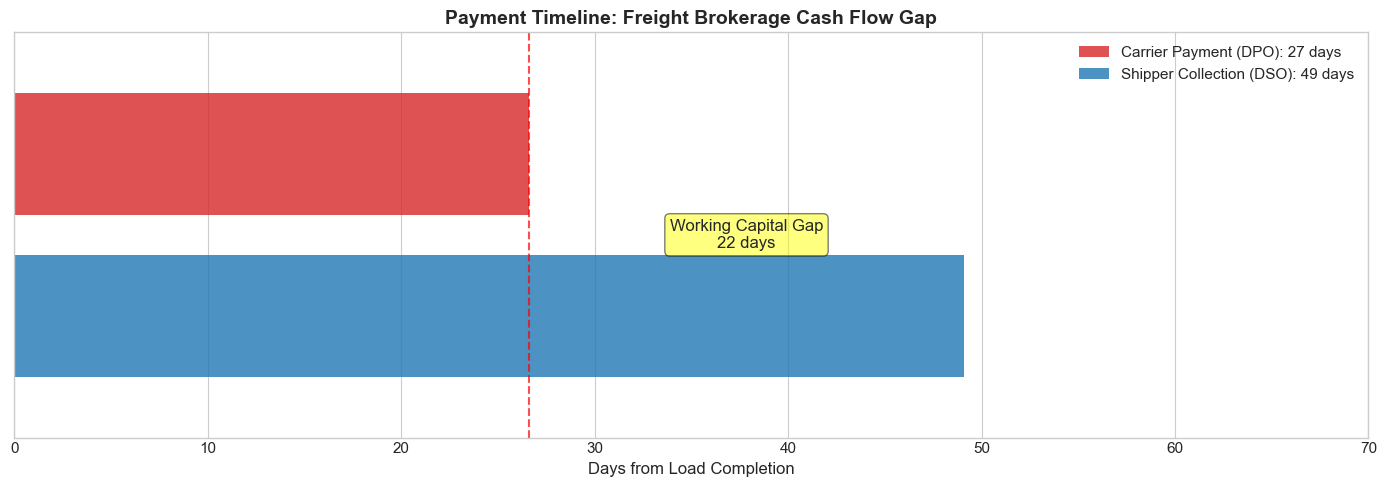

In [ ]:
# Visualize payment timing
fig, ax = plt.subplots(figsize=(14, 5))

# Timeline visualization
y_pos = 0.5
ax.barh(
    y_pos + 0.2,
    dpo_calculated,
    height=0.3,
    color=COLORS["cost"],
    label=f"Carrier Payment (DPO): {dpo_calculated:.0f} days",
    alpha=0.8,
)
ax.barh(
    y_pos - 0.2,
    dso_calculated,
    height=0.3,
    color=COLORS["traditional"],
    label=f"Shipper Collection (DSO): {dso_calculated:.0f} days",
    alpha=0.8,
)

# Working capital gap annotation
gap = dso_calculated - dpo_calculated
ax.axvline(x=dpo_calculated, color="red", linestyle="--", alpha=0.7)
ax.annotate(
    f"Working Capital Gap\n{gap:.0f} days",
    xy=(dpo_calculated + gap / 2, y_pos),
    fontsize=12,
    ha="center",
    va="center",
    bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.5),
)

ax.set_xlabel("Days from Load Completion", fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.legend(loc="upper right", fontsize=11)
ax.set_title(
    "Payment Timeline: Freight Brokerage Cash Flow Gap", fontsize=14, fontweight="bold"
)

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 3. Working Capital Analysis

Calculate the capital tied up in the payment cycle and associated financing costs.


In [6]:
# Initialize payment flow parameters with actual 10-K data
params = PaymentFlowParams(
    annual_revenue=metrics_2024["total_revenue"] * 1e6,  # Convert to dollars
    loads_per_year=metrics_2024["shipments_handled"],
    dso_days=metrics_2024["dso"],
    dpo_days=metrics_2024["dpo"],
    cost_of_capital=0.07,  # 7% WACC
    factoring_rate=0.03,  # 3% factoring fee
    fraud_loss_rate=0.005,  # 0.5% fraud losses
    admin_cost_per_load=15.0,
)

# Create traditional model
traditional = TraditionalPaymentModel(params)

print("Working Capital Analysis")
print("=" * 50)
print(f"Daily Revenue: {format_currency(params.daily_revenue)}")
print(f"Working Capital Gap: {params.working_capital_gap_days:.1f} days")
print(
    f"Capital Tied Up: {format_currency(traditional.calculate_working_capital_tied_up())}"
)
print(
    f"Annual Financing Cost (@7%): {format_currency(traditional.calculate_financing_cost())}"
)

Working Capital Analysis
Daily Revenue: $48.5M
Working Capital Gap: 22.5 days
Capital Tied Up: $1.1B
Annual Financing Cost (@7%): $76.2M


## 4. Cost Breakdown

Analyze all components of traditional payment infrastructure costs.


In [7]:
# Get full cost breakdown
cost_breakdown = traditional.get_cost_breakdown(pct_factored=0.30)

print("Traditional Payment Infrastructure Costs")
print("=" * 50)
for component, value in cost_breakdown.items():
    print(f"{component.replace('_', ' ').title():30s}: {format_currency(value)}")

Traditional Payment Infrastructure Costs
Working Capital Tied Up       : $1.1B
Financing Cost                : $76.2M
Factoring Cost                : $159.3M
Fraud Losses                  : $88.5M
Admin Costs                   : $235.5M
Total Cost                    : $559.5M


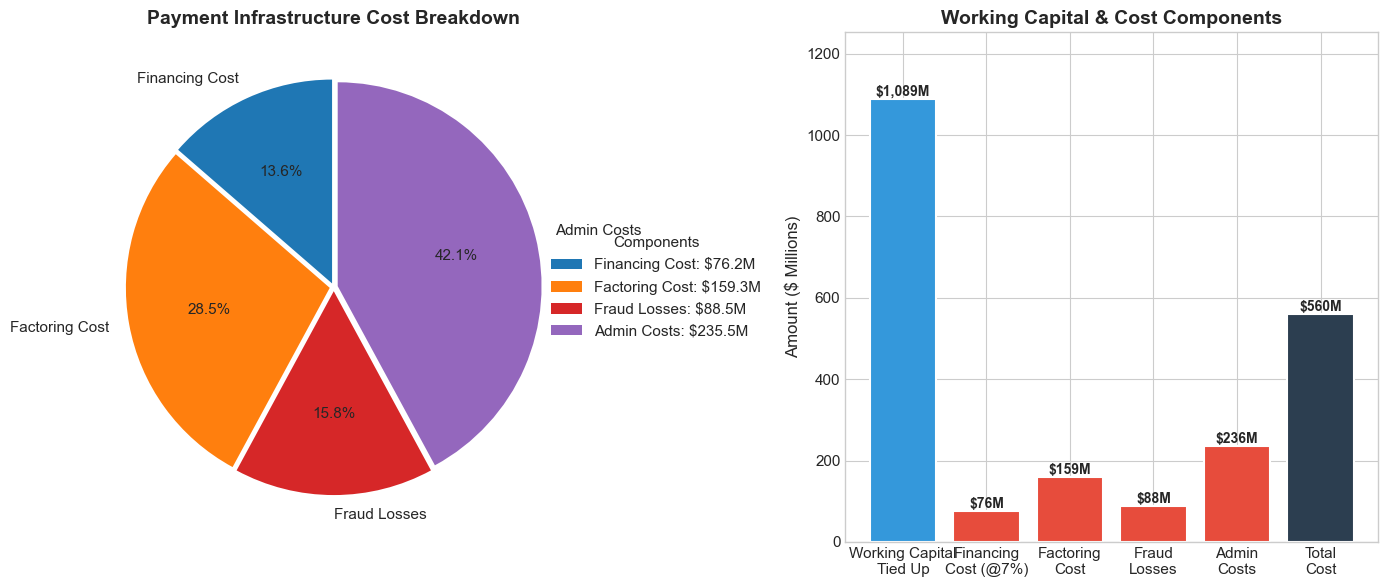

In [9]:
# Visualize cost breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart of cost components
cost_labels = ["Financing Cost", "Factoring Cost", "Fraud Losses", "Admin Costs"]
cost_values = [
    cost_breakdown["financing_cost"],
    cost_breakdown["factoring_cost"],
    cost_breakdown["fraud_losses"],
    cost_breakdown["admin_costs"],
]
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#9467bd"]

wedges, texts, autotexts = ax1.pie(
    cost_values,
    labels=cost_labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=(0.02, 0.02, 0.02, 0.02),
)
ax1.set_title("Payment Infrastructure Cost Breakdown", fontsize=14, fontweight="bold")

# Add values to legend
legend_labels = [f"{l}: {format_currency(v)}" for l, v in zip(cost_labels, cost_values)]
ax1.legend(
    wedges,
    legend_labels,
    title="Components",
    loc="center left",
    bbox_to_anchor=(0.9, 0, 0.5, 1),
)

# Waterfall chart
categories = [
    "Working Capital\nTied Up",
    "Financing\nCost (@7%)",
    "Factoring\nCost",
    "Fraud\nLosses",
    "Admin\nCosts",
    "Total\nCost",
]
values = [
    cost_breakdown["working_capital_tied_up"] / 1e6,
    cost_breakdown["financing_cost"] / 1e6,
    cost_breakdown["factoring_cost"] / 1e6,
    cost_breakdown["fraud_losses"] / 1e6,
    cost_breakdown["admin_costs"] / 1e6,
    cost_breakdown["total_cost"] / 1e6,
]

bar_colors = ["#3498db", "#e74c3c", "#e74c3c", "#e74c3c", "#e74c3c", "#2c3e50"]
bars = ax2.bar(categories, values, color=bar_colors, edgecolor="white", linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.annotate(
        f"${val:,.0f}M",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax2.set_ylabel("Amount ($ Millions)", fontsize=12)
ax2.set_title("Working Capital & Cost Components", fontsize=14, fontweight="bold")
ax2.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 5. Blockchain Payment Model Comparison

Compare traditional payment costs with blockchain-enabled instant settlement.


In [10]:
# Create blockchain model with 30% adoption
blockchain = BlockchainPaymentModel(params, adoption_rate=0.30, tx_cost_per_load=5.0)

# Compare models
comparison_results = compare_models(traditional, blockchain)

print("Model Comparison: Traditional vs. Blockchain (30% Adoption)")
print("=" * 60)
print(
    f"\nTraditional System Total Cost: {format_currency(comparison_results['traditional']['total_cost'])}"
)
print(
    f"Blockchain System Total Cost:  {format_currency(comparison_results['blockchain']['total_cost'])}"
)
print(
    f"\nNet Annual Savings: {format_currency(comparison_results['comparison']['net_savings'])}"
)
print(f"Savings Percentage: {comparison_results['comparison']['savings_pct']:.1f}%")
print(f"ROI on Blockchain Tx Costs: {comparison_results['comparison']['roi']:.1f}x")

Model Comparison: Traditional vs. Blockchain (30% Adoption)

Traditional System Total Cost: $559.5M
Blockchain System Total Cost:  $449.7M

Net Annual Savings: $109.8M
Savings Percentage: 19.6%
ROI on Blockchain Tx Costs: 4.7x


In [11]:
# Detailed savings breakdown
savings_breakdown = blockchain.get_savings_breakdown()

print("\nBlockchain Savings Breakdown (30% Adoption)")
print("=" * 50)
for component, value in savings_breakdown.items():
    prefix = "-" if "cost" in component.lower() else "+"
    print(
        f"{component.replace('_', ' ').title():30s}: {prefix}{format_currency(abs(value))}"
    )


Blockchain Savings Breakdown (30% Adoption)
Working Capital Reduction     : +$326.7M
Financing Savings             : +$22.9M
Factoring Savings             : +$47.8M
Fraud Savings                 : +$13.3M
Admin Savings                 : +$49.5M
Blockchain Costs              : -$23.6M
Net Savings                   : +$109.8M


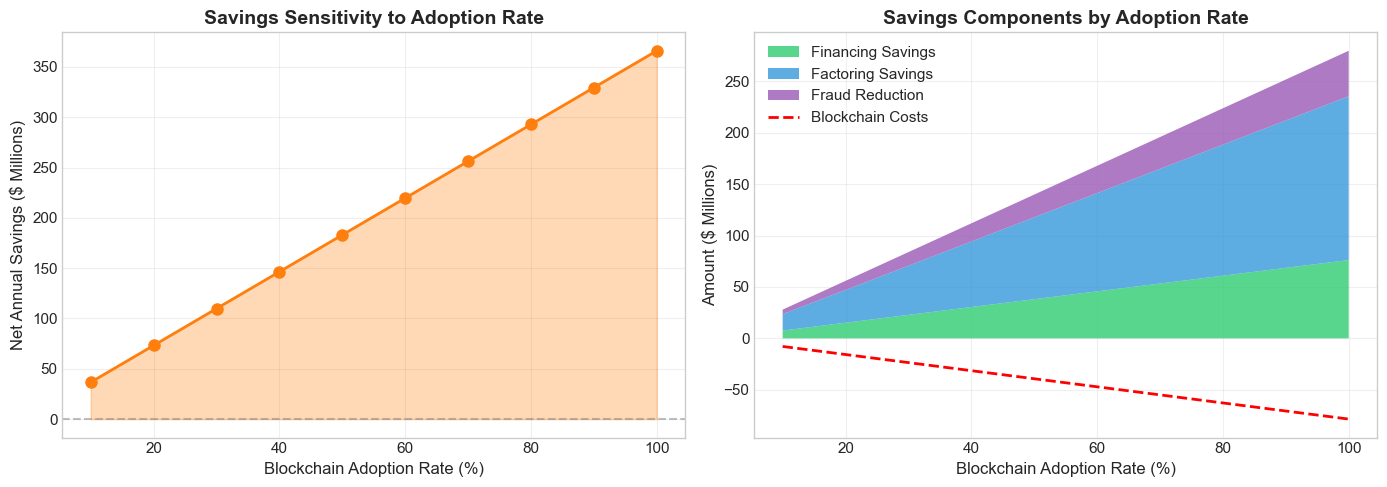

In [ ]:
# Sensitivity to adoption rate
adoption_results = sensitivity_to_adoption(params, tx_cost_per_load=5.0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Net savings by adoption rate
ax1.plot(
    [r * 100 for r in adoption_results["adoption_rate"]],
    [s / 1e6 for s in adoption_results["net_savings"]],
    "o-",
    color=COLORS["savings"],
    linewidth=2,
    markersize=8,
)
ax1.fill_between(
    [r * 100 for r in adoption_results["adoption_rate"]],
    [s / 1e6 for s in adoption_results["net_savings"]],
    alpha=0.3,
    color=COLORS["savings"],
)
ax1.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax1.set_xlabel("Blockchain Adoption Rate (%)", fontsize=12)
ax1.set_ylabel("Net Annual Savings ($ Millions)", fontsize=12)
ax1.set_title("Savings Sensitivity to Adoption Rate", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Stacked area chart of savings components
adoption_pcts = [r * 100 for r in adoption_results["adoption_rate"]]
financing = [s / 1e6 for s in adoption_results["financing_savings"]]
factoring = [s / 1e6 for s in adoption_results["factoring_savings"]]
fraud = [s / 1e6 for s in adoption_results["fraud_savings"]]
costs = [-c / 1e6 for c in adoption_results["blockchain_costs"]]

ax2.stackplot(
    adoption_pcts,
    financing,
    factoring,
    fraud,
    labels=["Financing Savings", "Factoring Savings", "Fraud Reduction"],
    colors=["#2ecc71", "#3498db", "#9b59b6"],
    alpha=0.8,
)
ax2.plot(adoption_pcts, costs, "r--", linewidth=2, label="Blockchain Costs")
ax2.set_xlabel("Blockchain Adoption Rate (%)", fontsize=12)
ax2.set_ylabel("Amount ($ Millions)", fontsize=12)
ax2.set_title("Savings Components by Adoption Rate", fontsize=14, fontweight="bold")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 6. Key Findings Summary


In [14]:
print("\n" + "=" * 70)
print("KEY FINDINGS: Payment Flow Cost Model Analysis")
print("=" * 70)

print("\n1. WORKING CAPITAL METRICS (from 10-K data)")
print(f"   - DSO: {metrics_2024['dso']:.1f} days (time to collect from shippers)")
print(f"   - DPO: {metrics_2024['dpo']:.1f} days (time to pay carriers)")
print(f"   - Working Capital Gap: {params.working_capital_gap_days:.1f} days")
print(
    f"   - Capital Tied Up: {format_currency(traditional.calculate_working_capital_tied_up())}"
)

print("\n2. TRADITIONAL PAYMENT COSTS")
print(
    f"   - Financing Cost: {format_currency(cost_breakdown['financing_cost'])} (@ 7% cost of capital)"
)
print(
    f"   - Factoring Cost: {format_currency(cost_breakdown['factoring_cost'])} (30% factored @ 3%)"
)
print(
    f"   - Fraud Losses: {format_currency(cost_breakdown['fraud_losses'])} (0.5% of revenue)"
)
print(f"   - Admin Costs: {format_currency(cost_breakdown['admin_costs'])} ($15/load)")
print(f"   - TOTAL: {format_currency(cost_breakdown['total_cost'])}")

print("\n3. BLOCKCHAIN IMPACT (30% Adoption)")
print(
    f"   - Working Capital Reduction: {format_currency(savings_breakdown['working_capital_reduction'])}"
)
print(
    f"   - Financing Savings: {format_currency(savings_breakdown['financing_savings'])}"
)
print(
    f"   - Factoring Savings: {format_currency(savings_breakdown['factoring_savings'])}"
)
print(f"   - Fraud Reduction: {format_currency(savings_breakdown['fraud_savings'])}")
print(
    f"   - Blockchain Costs: -{format_currency(savings_breakdown['blockchain_costs'])}"
)
print(f"   - NET SAVINGS: {format_currency(savings_breakdown['net_savings'])}")

print("\n4. CONCLUSION")
pct_of_revenue = savings_breakdown["net_savings"] / params.annual_revenue * 100
print(
    f"   Blockchain payment infrastructure could save {format_currency(savings_breakdown['net_savings'])} annually"
)
print(f"   at 30% adoption, representing {pct_of_revenue:.2f}% of total revenue.")
print("\n" + "=" * 70)


KEY FINDINGS: Payment Flow Cost Model Analysis

1. WORKING CAPITAL METRICS (from 10-K data)
   - DSO: 49.1 days (time to collect from shippers)
   - DPO: 26.6 days (time to pay carriers)
   - Working Capital Gap: 22.5 days
   - Capital Tied Up: $1.1B

2. TRADITIONAL PAYMENT COSTS
   - Financing Cost: $76.2M (@ 7% cost of capital)
   - Factoring Cost: $159.3M (30% factored @ 3%)
   - Fraud Losses: $88.5M (0.5% of revenue)
   - Admin Costs: $235.5M ($15/load)
   - TOTAL: $559.5M

3. BLOCKCHAIN IMPACT (30% Adoption)
   - Working Capital Reduction: $326.7M
   - Financing Savings: $22.9M
   - Factoring Savings: $47.8M
   - Fraud Reduction: $13.3M
   - Blockchain Costs: -$23.6M
   - NET SAVINGS: $109.8M

4. CONCLUSION
   Blockchain payment infrastructure could save $109.8M annually
   at 30% adoption, representing 0.62% of total revenue.

